In [182]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [183]:
# Load the datasets
print("Loading datasets...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("\nDataset shapes:")
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

# Display info about the training data
print("\nTraining data information:")
print(train_df.info())

# Separate features and target
target_column = train_df.columns[-1]  # Assuming 'label' is the last column
X = train_df.drop(columns=[target_column])  # X = all columns except the last. This is our features
y = train_df[target_column]  # y = last column. This is our target.

print("\nFeature and target shapes:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

Loading datasets...

Dataset shapes:
Training data: (640, 112)
Test data: (640, 112)

Training data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Columns: 112 entries, Source_IP to label
dtypes: float64(16), int64(92), object(4)
memory usage: 560.1+ KB
None

Feature and target shapes:
Features (X): (640, 111)
Target (y): (640,)


In [184]:
# Feature creation Stage 1 : in this stage we will create new features from the existing data. it will be addrd to the existing data

print("Creating and removing features...")

def create_features(df):
    
    # ------------------------------------------------------------------------------------------------------------------------Create timing-related features from network traffic data
    
    # Create a copy to avoid modifying original data
    df = df.copy()
    
    # 1. Basic packet timing features
    # Average time between packets (using forward and backward inter-arrival times)
    df['avg_packet_time'] = (df['mean_fwd_inter_arrival_time'] + df['mean_bwd_inter_arrival_time']) / 2
    
    # Time symmetry ratio (forward vs backward timing)
    df['time_symmetry_ratio'] = df['mean_fwd_inter_arrival_time'] / df['mean_bwd_inter_arrival_time'].replace(0, 1)
    
    # 2. Timing variability features
    # Timing volatility (difference between max and min timing)
    df['fwd_timing_volatility'] = df['max_fwd_inter_arrival_time'] - df['min_fwd_inter_arrival_time']
    df['bwd_timing_volatility'] = df['max_bwd_inter_arrival_time'] - df['min_bwd_inter_arrival_time']
    
    # 3. Derived timing metrics
    # Timing ratio between forward and backward volatility
    df['timing_volatility_ratio'] = df['fwd_timing_volatility'] / df['bwd_timing_volatility'].replace(0, 1)
    
    # 4. Packet rate features
    # Packets per second (forward and backward)
    df['fwd_packets_per_sec'] = df['fwd_packets_amount'] / df['mean_fwd_inter_arrival_time'].replace(0, 1)
    df['bwd_packets_per_sec'] = df['bwd_packets_amount'] / df['mean_bwd_inter_arrival_time'].replace(0, 1)
    
    # 5. Timing patterns
    # Ratio of minimum to maximum timing intervals
    df['fwd_timing_pattern'] = df['min_fwd_inter_arrival_time'] / df['max_fwd_inter_arrival_time'].replace(0, 1)
    df['bwd_timing_pattern'] = df['min_bwd_inter_arrival_time'] / df['max_bwd_inter_arrival_time'].replace(0, 1)
    
    # 6. Timing efficiency metrics
    # Average bytes per time unit
    df['fwd_bytes_per_time'] = df['fwd_packets_length'] / df['mean_fwd_inter_arrival_time'].replace(0, 1)
    df['bwd_bytes_per_time'] = df['bwd_packets_length'] / df['mean_bwd_inter_arrival_time'].replace(0, 1)
    
    # 7. Advanced timing features
    # Timing regularity score (using coefficient of variation)
    df['fwd_timing_regularity'] = df['mean_fwd_inter_arrival_time'] / df['max_fwd_inter_arrival_time'].replace(0, 1)
    df['bwd_timing_regularity'] = df['mean_bwd_inter_arrival_time'] / df['max_bwd_inter_arrival_time'].replace(0, 1)
    
    # 8. Bidirectional timing features
    # Overall session timing characteristics
    df['total_session_time'] = df['mean_bib_inter_arrival_time'] * (df['fwd_packets_amount'] + df['bwd_packets_amount'])
    df['session_timing_symmetry'] = abs(df['fwd_timing_volatility'] - df['bwd_timing_volatility']) / (df['fwd_timing_volatility'] + df['bwd_timing_volatility']).replace(0, 1)

    # -----------------------------------------------------------------------------------------------------------------------------------------------------Create timestamp-related features

    df['hour'] = pd.to_datetime(df['Timestamp'], unit='s').dt.hour
    # df['minute'] = pd.to_datetime(df['Timestamp'], unit='s').dt.minute
    df['day_of_week'] = pd.to_datetime(df['Timestamp'], unit='s').dt.dayofweek
    
    return df

# Apply the feature creation to both training and test sets
X = create_features(X)
test_df = create_features(test_df)

print(f"Added {len(X.columns) - len(train_df.columns)} new features")
print(f"The additional features are: {set(X.columns) - set(train_df.columns)}")

# Remove the 'Timestamp' column
X = X.drop(columns=['Timestamp'])
test_df = test_df.drop(columns=['Timestamp'])

# Remove the 'Source_port' column
X = X.drop(columns=['Source_port'])
test_df = test_df.drop(columns=['Source_port'])

# Remove the 'Source_IP' column:
X = X.drop(columns=['Source_IP'])
test_df = test_df.drop(columns=['Source_IP'])



Creating and removing features...
Added 16 new features
The additional features are: {'fwd_timing_volatility', 'fwd_bytes_per_time', 'total_session_time', 'timing_volatility_ratio', 'bwd_timing_volatility', 'fwd_timing_pattern', 'bwd_timing_pattern', 'fwd_packets_per_sec', 'bwd_packets_per_sec', 'session_timing_symmetry', 'bwd_bytes_per_time', 'hour', 'avg_packet_time', 'time_symmetry_ratio', 'day_of_week', 'bwd_timing_regularity', 'fwd_timing_regularity'}


In [185]:
# Feature creation Stage 2 : The second sttage of feature creation will be performed after the model is trained and operated on the data. 
def create_enhanced_features(df):
    """
    Create additional features to help distinguish commonly confused websites
    """
    df = df.copy()
    
    # 1. Traffic Pattern Features
    # Burst pattern detection (helpful for news/social media sites)
    df['burst_ratio'] = df.apply(lambda row: calculate_burst_ratio(
        [row[f'first_packet_sizes_{i}'] for i in range(30)]
    ), axis=1)
    # Traffic symmetry (helps distinguish interactive vs content-delivery sites)
    df['traffic_symmetry'] = (df['fwd_packets_length'] - df['bwd_packets_length']) / (df['fwd_packets_length'] + df['bwd_packets_length'])
    
    # 2. Timing-based Features
    # Request-response pattern (helps identify API-heavy sites like social media)
    df['request_response_ratio'] = df['mean_fwd_inter_arrival_time'] / df['mean_bwd_inter_arrival_time']
    # Timing regularity (helps identify CDN vs dynamic content)
    df['timing_regularity'] = df['STD_packet_size'] / df['mean_packet_size']
    
    # 3. Size-based Features
    # Initial handshake pattern (first 3 packets)
    df['initial_handshake_pattern'] = df.apply(lambda row: calculate_handshake_pattern(
        [row[f'first_packet_sizes_{i}'] for i in range(3)]
    ), axis=1)
    # Content delivery pattern
    df['content_delivery_ratio'] = calculate_content_delivery_ratio(df)
    
    # 4. Protocol-specific Features
    # Push flag density (helps identify streaming/real-time content)
    df['push_density'] = df['PSH_count'] / (df['fwd_packets_amount'] + df['bwd_packets_amount'])
    
    # 5. Advanced Traffic Analysis
    # Bandwidth variation (helps identify media-rich sites)
    bandwidth_cols = [col for col in df.columns if col.startswith('bandwidth_')]
    df['bandwidth_variation'] = df[bandwidth_cols].std(axis=1)
    
    return df

def calculate_burst_ratio(packet_sizes):
    """Calculate ratio of burst packets to total packets"""
    mean_size = np.mean([abs(size) for size in packet_sizes if size != 0])
    burst_packets = sum(1 for size in packet_sizes if abs(size) > 2 * mean_size)
    return burst_packets / len(packet_sizes)

def calculate_handshake_pattern(first_three_packets):
    """Create a numerical representation of the initial handshake pattern"""
    pattern = 0
    for i, size in enumerate(first_three_packets):
        if size > 0:
            pattern += 2 ** (i * 2)
        elif size < 0:
            pattern += 2 ** (i * 2 + 1)
    return pattern

def calculate_content_delivery_ratio(df):
    """Calculate ratio of large response packets to total packets"""
    large_responses = df['bwd_packets_length'] / df['max_bwd_packet']
    return large_responses / (df['fwd_packets_amount'] + df['bwd_packets_amount'])


In [186]:
# Features creation Stage 3 : The third stage of feature creation will be performed after the model is trained and operated on the data.

def safe_division(a, b, default=0):
    """Safe division that returns default value when denominator is 0"""
    return np.where(b != 0, a / b, default)

def create_social_media_features(df):
    """
    Create features with safe division operations
    """
    df = df.copy()
    
    # Safe divisions with handling for zeros
    df['large_response_ratio'] = safe_division(
        df['bwd_packets_length'],
        (df['fwd_packets_length'] + df['bwd_packets_length'])
    )
    
    df['interaction_density'] = safe_division(
        df['fwd_packets_amount'],
        df['mean_fwd_inter_arrival_time']
    )
    
    df['timing_consistency'] = safe_division(
        (df['max_bwd_inter_arrival_time'] - df['min_bwd_inter_arrival_time']),
        df['mean_bwd_inter_arrival_time']
    )
    
    df['packet_size_consistency'] = safe_division(
        df['STD_packet_size'],
        df['mean_packet_size']
    )
    
    df['traffic_pattern'] = safe_division(
        df['bwd_packets_length'] * df['mean_bwd_inter_arrival_time'],
        df['fwd_packets_length'] * df['mean_fwd_inter_arrival_time']
    )
    
    return df

def create_targeted_features(df):
    """
    Create targeted features with safe division operations
    """
    df = df.copy()
    
    # Content consistency with safe division
    df['content_consistency'] = safe_division(
        df['mean_bwd_inter_arrival_time'] * df['mean_packet_size'],
        df['STD_packet_size'] + 1
    )
    
    # Interactive ratio with safe division
    df['interactive_ratio'] = safe_division(
        df['fwd_packets_amount'] * df['min_fwd_packet'],
        df['bwd_packets_amount'] * df['min_bwd_packet'] + 1
    )
    
    # Resource access pattern
    first_10_packets = [f'first_packet_sizes_{i}' for i in range(10)]
    mean_packet_size = df['mean_packet_size'].mean()
    df['resource_access_pattern'] = df[first_10_packets].apply(
        lambda x: sum(1 for size in x if abs(size) > mean_packet_size)
    )
    
    # Bidirectional ratio
    df['bidirectional_ratio'] = safe_division(
        df['fwd_packets_amount'],
        df['bwd_packets_amount'] + 1
    )
    
    # Timing pattern
    df['timing_pattern'] = safe_division(
        df['max_bwd_inter_arrival_time'],
        df['mean_bwd_inter_arrival_time']
    )
    
    # Media content ratio
    df['media_content_ratio'] = safe_division(
        df['max_bwd_packet'],
        df['mean_packet_size']
    )
    
    # Session features
    df['session_interactivity'] = safe_division(
        df['PSH_count'],
        df['fwd_packets_amount'] + df['bwd_packets_amount']
    )
    
    # Calculate bandwidth variation if columns exist
    bandwidth_cols = [col for col in df.columns if col.startswith('bandwidth_')]
    if bandwidth_cols:
        df['bandwidth_variation'] = df[bandwidth_cols].std(axis=1)
        
        # Features using bandwidth variation
        df['streaming_pattern'] = safe_division(
            df['mean_packet_size'] * df['bandwidth_variation'],
            df['STD_packet_size'] + 1
        )
        
        df['content_update_pattern'] = safe_division(
            df['mean_bib_inter_arrival_time'] * df['bandwidth_variation'],
            df['STD_packet_size'] + 1
        )
        
        df['technical_content_pattern'] = safe_division(
            df['mean_packet_size'] * df['bandwidth_variation'],
            df['STD_packet_size'] + 1
        )
    
    # Session intensity
    df['session_intensity'] = safe_division(
        df['PSH_count'],
        df['fwd_packets_amount'] + df['bwd_packets_amount']
    )

    # Size variation
    df['size_variation'] = safe_division(
        df['STD_packet_size'],
        df['mean_packet_size']
    )
    
    # Initial pattern from first packets
    df['initial_pattern'] = df.apply(
        lambda row: sum([1 if row[f'first_packet_sizes_{i}'] > 0 else -1 
                        for i in range(5)]),
        axis=1
    )
    
    # Replace any remaining infinities or NaNs with 0
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    
    return df

In [187]:
# First, create all targeted features:
print("Creating targeted features for all data...")

# Create social media features
social_media_features_train = pd.DataFrame(index=X.index)
social_media_features_test = pd.DataFrame(index=test_df.index)

# Create and store social media features
social_media_features = create_social_media_features(X)
social_media_cols = [col for col in social_media_features.columns 
                    if col not in X.columns]
social_media_features_train = social_media_features[social_media_cols]

social_media_features = create_social_media_features(test_df)
social_media_features_test = social_media_features[social_media_cols]

# Create and store targeted features
targeted_features_train = pd.DataFrame(index=X.index)
targeted_features_test = pd.DataFrame(index=test_df.index)

targeted_features = create_targeted_features(X)
targeted_cols = [col for col in targeted_features.columns 
                if col not in X.columns and col not in social_media_cols]
targeted_features_train = targeted_features[targeted_cols]

targeted_features = create_targeted_features(test_df)
targeted_features_test = targeted_features[targeted_cols]

# Create and store enhanced features
enhanced_features_train = pd.DataFrame(index=X.index)
enhanced_features_test = pd.DataFrame(index=test_df.index)

enhanced_features = create_enhanced_features(X)
enhanced_cols = [col for col in enhanced_features.columns 
                if col not in X.columns and col not in social_media_cols and col not in targeted_cols]
enhanced_features_train = enhanced_features[enhanced_cols]

enhanced_features = create_enhanced_features(test_df)
enhanced_features_test = enhanced_features[enhanced_cols]

print(f"Created {len(social_media_cols)} social media features")
print(f"Created {len(targeted_cols)} targeted features")
print(f"Created {len(enhanced_cols)} enhanced features")


Creating targeted features for all data...
Created 5 social media features
Created 14 targeted features
Created 7 enhanced features


In [188]:
# Handle categorical columns
print("\nHandling categorical columns...")
categorical_columns = X.select_dtypes(include=['object']).columns  # Select object type columns
print(f"Found {len(categorical_columns)} categorical columns: {list(categorical_columns)}")

# Initialize label encoders dictionary
label_encoders = {}

# Encode categorical columns
for col in categorical_columns:
    print(f"\nEncoding column: {col}")
    print(f"Original unique values: {X[col].nunique()}")
    
    le = LabelEncoder()
    # Combine train and test data for encoding
    combined_data = pd.concat([X[col], test_df[col]])
    le.fit(combined_data.astype(str))
    
    # Transform both training and test data
    X[col] = le.transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    
    label_encoders[col] = le
    print(f"Encoded unique values: {len(le.classes_)}")



Handling categorical columns...
Found 2 categorical columns: ['Destination_IP', 'Protocol']

Encoding column: Destination_IP
Original unique values: 330
Encoded unique values: 468

Encoding column: Protocol
Original unique values: 2
Encoded unique values: 2


In [189]:
# First, let's see what columns we have in both datasets
print("Training data columns:", X.columns.tolist())
print("\nTest data columns:", test_df.columns.tolist())

# Check data types for both datasets
print("\nTraining data types:")
print(X.dtypes)
print("\nTest data types:")
print(test_df.dtypes)

# Function to find problematic values in a DataFrame
def find_problematic_values(df):
    for column in df.columns:
        try:
            df[column].astype(float)
        except ValueError:
            print(f"\nProblematic column: {column}")
            print("Sample unique values:", df[column].unique()[:5])
            print("Number of unique values:", df[column].nunique())

print("\nChecking problematic values in training data:")
find_problematic_values(X)

print("\nChecking problematic values in test data:")
find_problematic_values(test_df)

# Let's handle the encoding more carefully
categorical_columns = []
for column in X.columns:
    # Check if column contains any non-numeric values
    if not pd.to_numeric(X[column], errors='coerce').notnull().all() or \
       not pd.to_numeric(test_df[column], errors='coerce').notnull().all():
        categorical_columns.append(column)

print("\nIdentified categorical columns:", categorical_columns)

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    print(f"\nProcessing column: {col}")
    le = LabelEncoder()
    # Combine unique values from both train and test
    combined_values = pd.concat([X[col], test_df[col]]).unique()
    le.fit(combined_values.astype(str))
    
    # Transform the data
    X[col] = le.transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Now try converting to float again
try:
    X = X.astype(float)
    print("\nSuccessfully converted training data to float")
except ValueError as e:
    print("\nError in converting training data:", e)
    
try:
    test_df = test_df.astype(float)
    print("Successfully converted test data to float")
except ValueError as e:
    print("\nError in converting test data:", e)

# Verify final data types
print("\nFinal data types - Training:")
print(X.dtypes.value_counts())
print("\nFinal data types - Test:")
print(test_df.dtypes.value_counts())

# Additional verification step
print("\nVerifying no remaining string values:")
for column in X.columns:
    try:
        X[column].astype(float)
        test_df[column].astype(float)
    except ValueError:
        print(f"Column {column} still contains non-numeric values")


Training data columns: ['Destination_IP', 'Destination_port', 'Protocol', 'fwd_packets_amount', 'bwd_packets_amount', 'fwd_packets_length', 'bwd_packets_length', 'max_fwd_packet ', 'min_fwd_packet', 'max_bwd_packet', 'min_bwd_packet', 'FIN_count', 'SYN_count', 'RST_count', 'PSH_count', 'silence_windows', 'min_fwd_inter_arrival_time', 'max_fwd_inter_arrival_time', 'mean_fwd_inter_arrival_time', 'min_bwd_inter_arrival_time', 'max_bwd_inter_arrival_time', 'mean_bwd_inter_arrival_time', 'min_bib_inter_arrival_time', 'max_bib_inter_arrival_time', 'mean_bib_inter_arrival_time', 'first_packet_sizes_0', 'first_packet_sizes_1', 'first_packet_sizes_2', 'first_packet_sizes_3', 'first_packet_sizes_4', 'first_packet_sizes_5', 'first_packet_sizes_6', 'first_packet_sizes_7', 'first_packet_sizes_8', 'first_packet_sizes_9', 'first_packet_sizes_10', 'first_packet_sizes_11', 'first_packet_sizes_12', 'first_packet_sizes_13', 'first_packet_sizes_14', 'first_packet_sizes_15', 'first_packet_sizes_16', 'first

In [190]:
first_selection_threshold = 0.95
second_selection_lower_threshold = 0.85
second_selection_upper_threshold = 0.97
## First selection: Features with same value in 97% or more of the data
def find_constant_features(df, threshold=0.97):
    constant_features = []
    for column in df.columns:
        # Calculate the proportion of the most frequent value
        most_frequent_prop = df[column].value_counts(normalize=True).iloc[0]
        if most_frequent_prop >= threshold:
            constant_features.append(column)
    
    return constant_features

# Second selection: Check distribution of features with same value in 85-97% of data
def analyze_near_constant_features(df, y, lower_threshold=0.85, upper_threshold=0.98):
    features_to_remove = []
    total_classes = len(np.unique(y))
    
    print(f"Total number of classes in dataset: {total_classes}")
    
    # Expected uniform distribution probability
    uniform_prob = 1.0 / total_classes
    # Allow some deviation from uniform (e.g., 2x the uniform probability)
    max_allowed_prob = uniform_prob * 2
    
    for column in df.columns:
        # Get value counts and proportions
        value_counts = df[column].value_counts(normalize=True)
        most_frequent_prop = value_counts.iloc[0]
        most_frequent_value = value_counts.index[0]
        
        # If feature has same value in 85-97% of data
        if lower_threshold <= most_frequent_prop < upper_threshold:
            # Get the minority cases (where value is different from most frequent)
            minority_mask = df[column] != most_frequent_value
            minority_labels = y[minority_mask]
            
            # Check distribution of classes in minority cases
            class_distribution = minority_labels.value_counts(normalize=True)
            
            # print(f"\nAnalyzing feature: {column}")
            # print(f"Most frequent value appears in {most_frequent_prop:.2%} of data")
            # print("Class distribution in minority cases:")
            # print(class_distribution)
            
            # Analyze distribution
            if len(class_distribution) > 1:  # Only if there are multiple classes
                max_class_prop = class_distribution.max()
                
                # Calculate entropy of distribution
                entropy = -sum(p * np.log2(p) for p in class_distribution)
                max_entropy = -np.log2(1/total_classes)  # Maximum possible entropy
                entropy_ratio = entropy / max_entropy
                
                print(f"Entropy ratio: {entropy_ratio:.2f} (1.0 would be perfectly uniform)")
                
                # Decision criteria:
                # 1. If any class is heavily overrepresented
                # 2. Or if distribution is close to uniform
                if max_class_prop < max_allowed_prob or entropy_ratio > 0.8:
                    features_to_remove.append(column)
                    print("REMOVED: Distribution is too uniform or lacks clear class separation")
                else:
                    print("KEPT: Shows significant class separation")
            else:
                print("KEPT: Only one class in minority cases (strong predictor)")
                
    return features_to_remove

# Apply the feature selection
print("Starting feature selection...")
print(f"Number of unique classes in dataset: {len(np.unique(y))}")

# First stage: Remove highly constant features
constant_features = find_constant_features(X, first_selection_threshold)
print(f"\nFound {len(constant_features)} features with {first_selection_threshold}% constant values:")
for feat in constant_features:
    value_counts = X[feat].value_counts(normalize=True)
    print(f"{feat}: Most common value appears in {value_counts.iloc[0]:.2%} of cases")

# Remove these features
X = X.drop(columns=constant_features)
test_df = test_df.drop(columns=constant_features)

# Second stage: Analyze near-constant features
features_to_remove = analyze_near_constant_features(X, y, second_selection_lower_threshold, second_selection_upper_threshold)
print(f"\nFound {len(features_to_remove)} near-constant features to remove:")
for feat in features_to_remove:
    print(f"\n{feat}:")
    value_counts = X[feat].value_counts(normalize=True)
    print(f"Value distribution: {value_counts.head()}")

# Remove these features
X = X.drop(columns=features_to_remove)
test_df = test_df.drop(columns=features_to_remove)

print("\nFeature selection completed.")
print(f"Number of features after selection: {X.shape[1]}")
print("\nRemoved features summary:")
print(f"- {len(constant_features)} highly constant features {first_selection_threshold}")
print(f"- {len(features_to_remove)} near-constant features with uniform class distribution")

Starting feature selection...
Number of unique classes in dataset: 128

Found 35 features with 0.95% constant values:
Destination_port: Most common value appears in 98.91% of cases
min_bib_inter_arrival_time: Most common value appears in 96.25% of cases
bandwidth_0: Most common value appears in 98.28% of cases
bandwidth_4: Most common value appears in 97.34% of cases
bandwidth_6: Most common value appears in 99.06% of cases
bandwidth_8: Most common value appears in 99.84% of cases
bandwidth_10: Most common value appears in 99.69% of cases
bandwidth_11: Most common value appears in 95.47% of cases
bandwidth_12: Most common value appears in 100.00% of cases
bandwidth_13: Most common value appears in 96.25% of cases
bandwidth_14: Most common value appears in 99.84% of cases
bandwidth_15: Most common value appears in 96.56% of cases
bandwidth_16: Most common value appears in 100.00% of cases
bandwidth_17: Most common value appears in 96.72% of cases
bandwidth_18: Most common value appears 

In [191]:
def plot_confusion_matrix(y_true, y_pred, figsize=(20, 20), threshold=2, samples_per_class=5):
    """
    Create and plot a confusion matrix, and analyze chronic misclassifications.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    figsize : tuple
        Figure size for the plot (width, height)
    threshold : int
        Minimum number of misclassifications to consider it chronic
    samples_per_class : int
        Number of samples per class (default=5)
    """
    # Get unique labels (sorted to ensure consistent order)
    labels = sorted(list(set(list(y_true) + list(y_pred))))
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Create confusion matrix DataFrame for analysis
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    # Create figure and axes
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(
        cm,
        xticklabels=labels,
        yticklabels=labels,
        annot=True,
        fmt='g',
        cmap='Blues',
        square=True,
        cbar=True,
        annot_kws={'size': 8}
    )
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Set labels and title
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Confusion Matrix')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Analyze chronic misclassifications
    print(f"\nAnalyzing chronic misclassifications (threshold >= {threshold}):\n")
    print("Format: ACTUAL_WEBSITE was misclassified as PREDICTED_WEBSITE X times\n")
    
    # Find and display chronic misclassifications
    found_misclassifications = False
    chronic_misclassifications = []
    
    for actual_site in labels:
        for predicted_site in labels:
            if actual_site != predicted_site:
                misclassification_count = cm_df.loc[actual_site, predicted_site]
                if misclassification_count >= threshold:
                    found_misclassifications = True
                    msg = f"MISS: '{actual_site}' was misclassified as '{predicted_site}' : {misclassification_count} times"
                    print(msg)
                    chronic_misclassifications.append({
                        'actual': actual_site,
                        'predicted': predicted_site,
                        'count': misclassification_count,
                        'percentage': (misclassification_count / samples_per_class) * 100
                    })
    
    if not found_misclassifications:
        print("No chronic misclassifications found with the current threshold.")
    
    # Display percentages for all misclassifications
    print("\nMisclassification Percentages (all cases):")
    print("-" * 50)
    for actual_site in labels:
        for predicted_site in labels:
            if actual_site != predicted_site:
                misclassification_count = cm_df.loc[actual_site, predicted_site]
                if misclassification_count > 0:
                    percentage = (misclassification_count / samples_per_class) * 100
                    print(f"{actual_site} → {predicted_site}: {percentage:.1f}% ({misclassification_count}/{samples_per_class} samples)")
    
    # Find perfect classifications
    print("\nPerfect Classifications:")
    print("-" * 50)
    perfect_classes = []
    
    for label in labels:
        # Get row and column for this class
        row = cm_df.loc[label]  # All predictions for actual class
        col = cm_df[label]      # All predictions as this class
        
        # Check if classification is perfect:
        # 1. All actual samples were correctly classified (row sum equals samples_per_class and all in diagonal)
        # 2. No other samples were classified as this class (no false positives in column)
        if (row.sum() == samples_per_class and  # All samples accounted for
            row[label] == samples_per_class and  # All samples correctly classified
            col.sum() == samples_per_class):     # No false positives
            perfect_classes.append(label)
    
    if perfect_classes:
        print("\nThe following classes had perfect classification (no false positives or false negatives):")
        for cls in sorted(perfect_classes):
            print(f"- {cls}")
        print("\n Number of classes achieved perfect classification: ", len(perfect_classes))
    else:
        print("\nNo classes achieved perfect classification.")

    return chronic_misclassifications, perfect_classes

In [192]:
# Initialize and train the Random Forest model
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=300,          # More trees for better stability
    max_depth=None,            # Control tree depth to prevent overfitting
    min_samples_split=5,       # Minimum samples required to split
    min_samples_leaf=2,        # Minimum samples in leaf nodes
    max_features='sqrt',       # Number of features to consider at each split
    class_weight='balanced',   # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X, y)
print("\nModel trained on full training dataset")


Training Random Forest model...

Model trained on full training dataset



Generating feature importance plot...


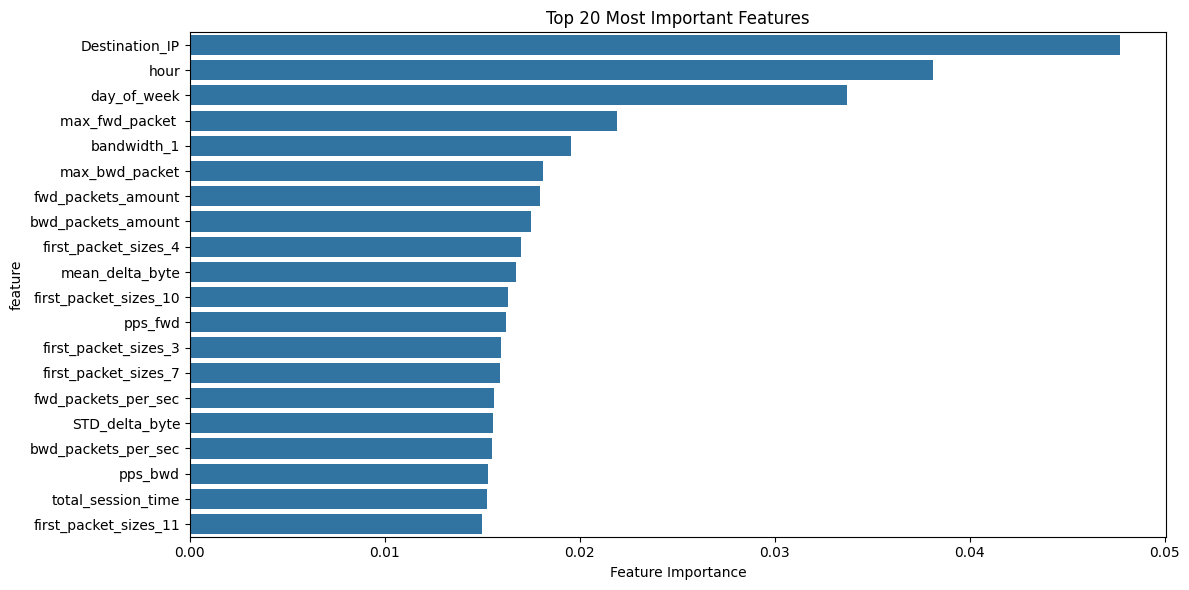

In [193]:
# Feature importance plot
print("\nGenerating feature importance plot...")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})

feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()


Making predictions on test set...

Prediction counts:
ssrn                   15
resources              14
slate                  11
buzzfeed               11
disneymovieinsiders    10
                       ..
bloomberg               2
disneystore             2
github                  2
businessinsider         1
facebook                1
Name: count, Length: 125, dtype: int64

Test Set Performance:

Classification Report:
                       precision    recall  f1-score   support

             1inch.io       0.50      0.40      0.44         5
   20thcenturystudios       0.75      0.60      0.67         5
              YouTube       0.67      0.40      0.50         5
        aboutads.info       1.00      0.80      0.89         5
   adventuresbydisney       0.50      0.60      0.55         5
alainelkanninterviews       1.00      1.00      1.00         5
           algemeiner       1.00      1.00      1.00         5
            amazonaws       0.71      1.00      0.83         5
     

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

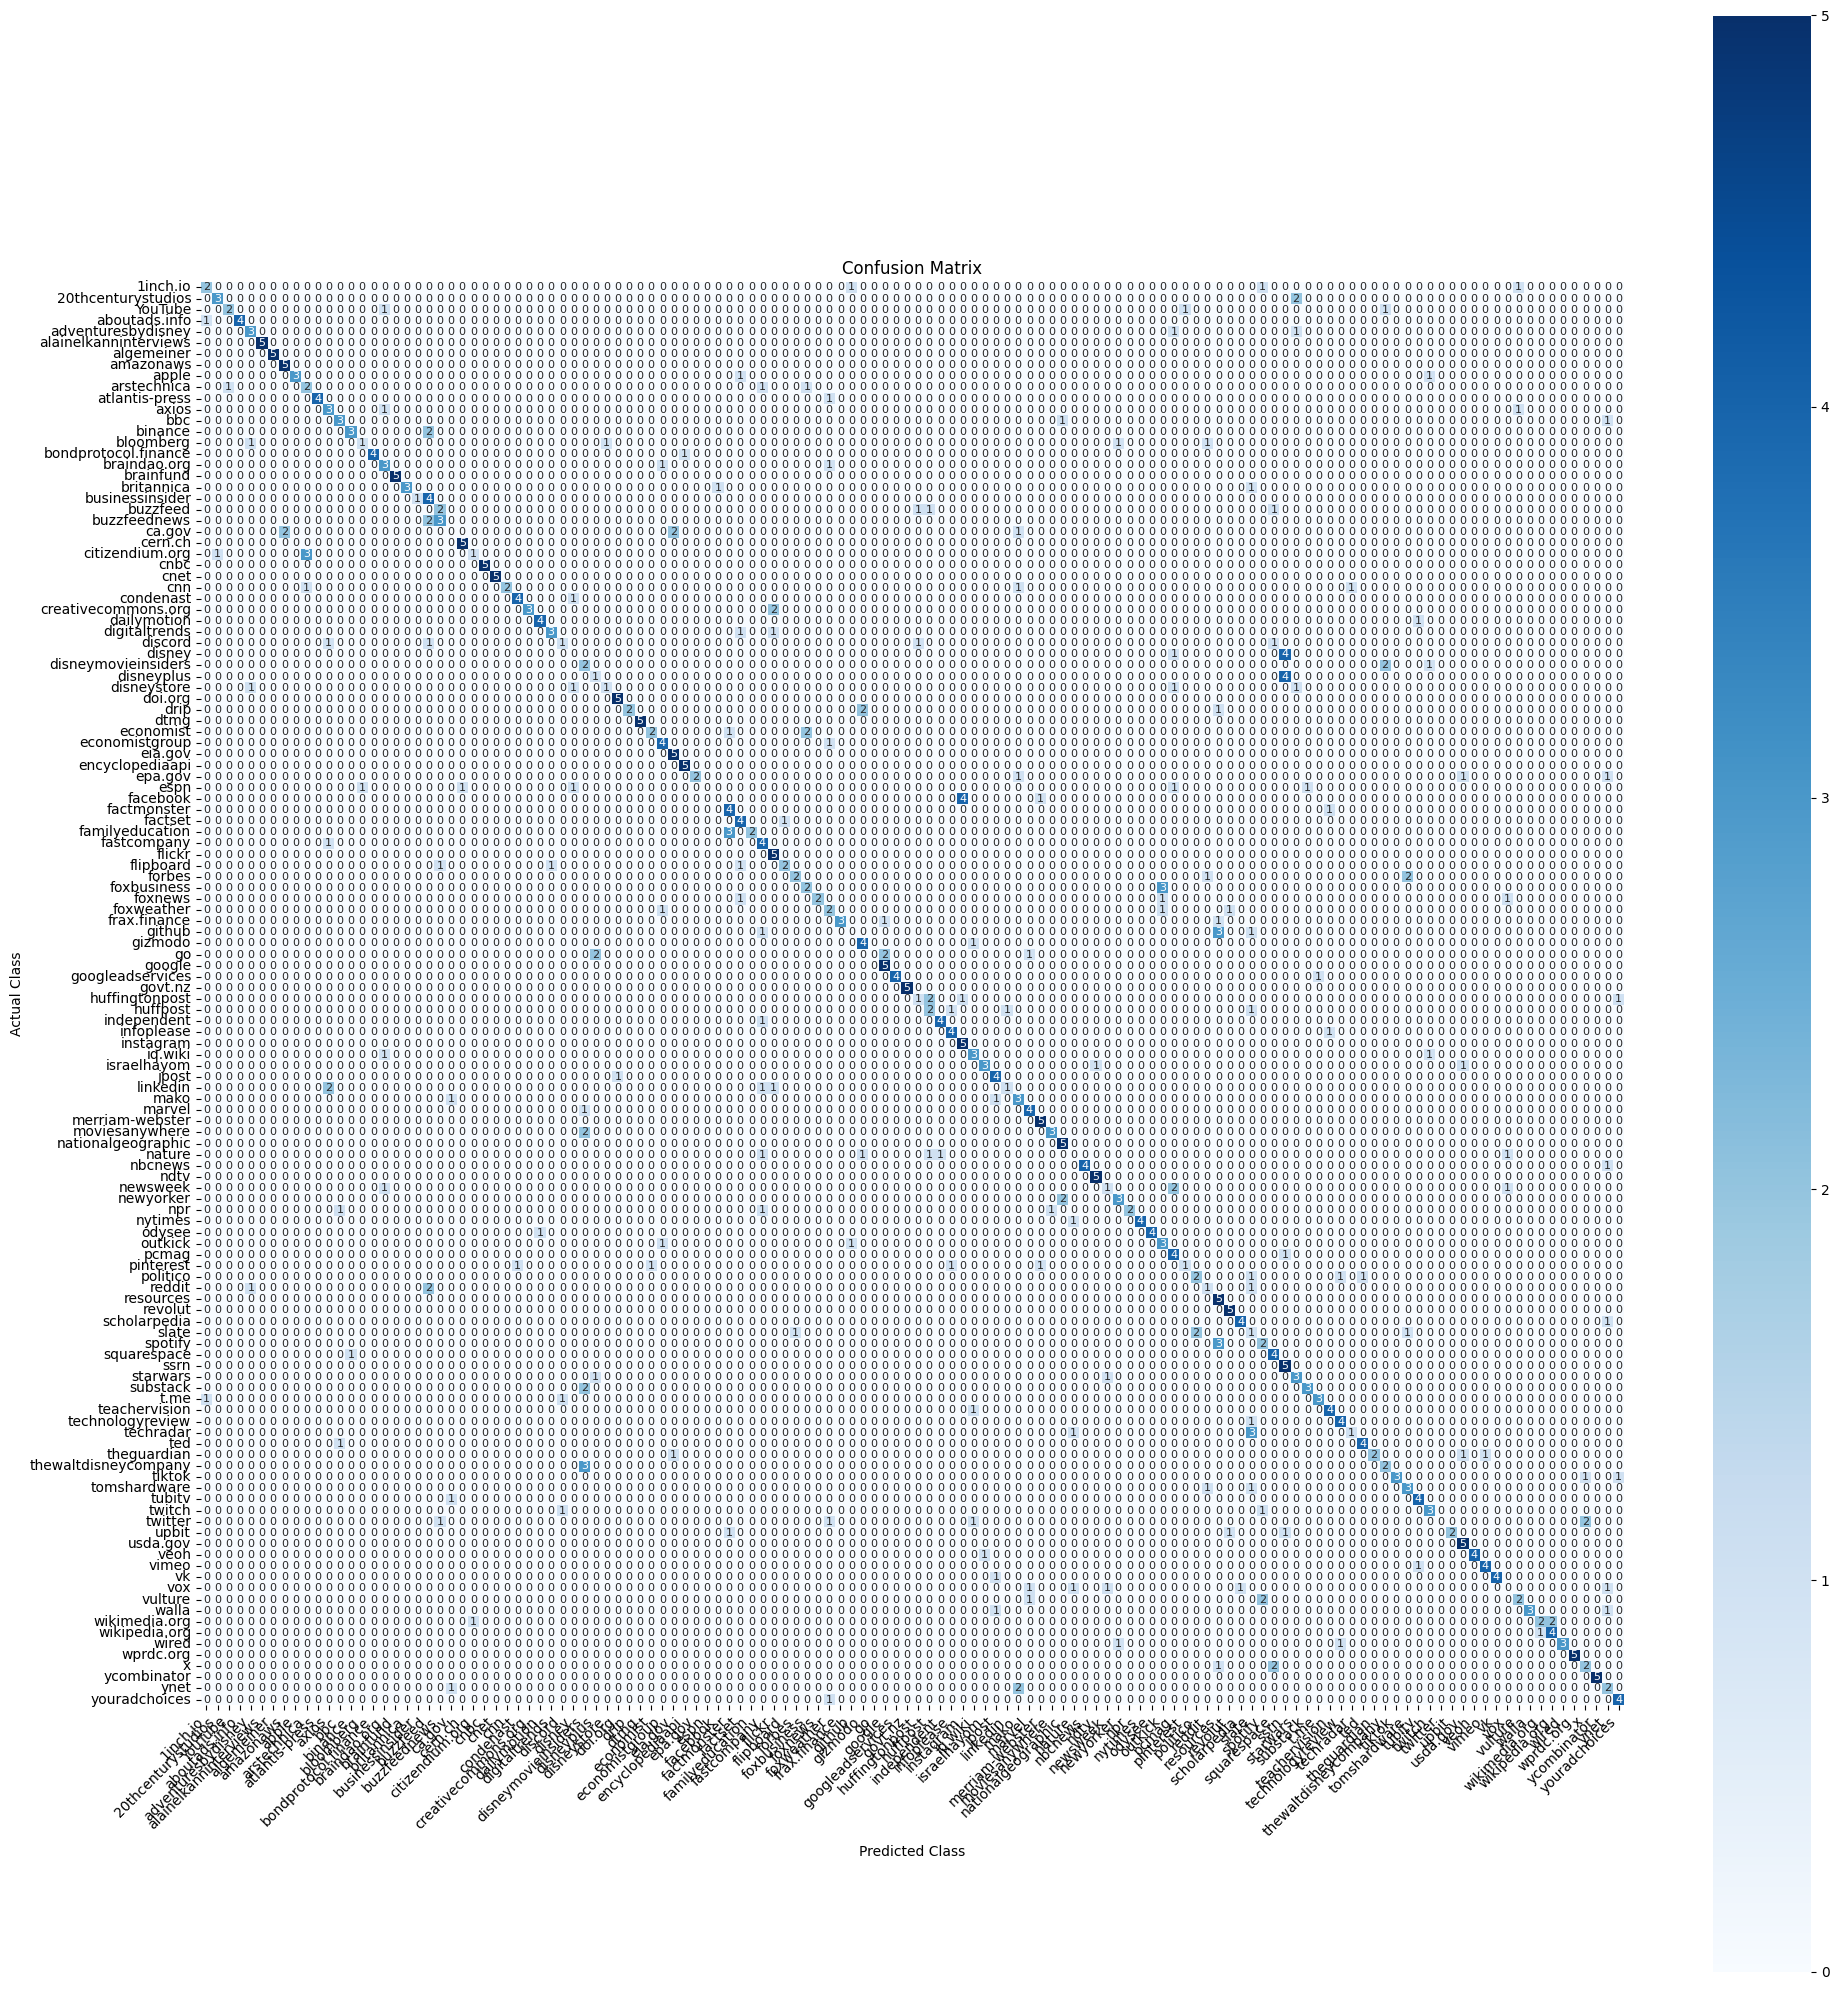


Analyzing chronic misclassifications (threshold >= 2):

Format: ACTUAL_WEBSITE was misclassified as PREDICTED_WEBSITE X times

MISS: '20thcenturystudios' was misclassified as 'starwars' : 2 times
MISS: 'binance' was misclassified as 'buzzfeed' : 2 times
MISS: 'businessinsider' was misclassified as 'buzzfeed' : 4 times
MISS: 'buzzfeed' was misclassified as 'buzzfeednews' : 2 times
MISS: 'buzzfeednews' was misclassified as 'buzzfeed' : 2 times
MISS: 'ca.gov' was misclassified as 'amazonaws' : 2 times
MISS: 'ca.gov' was misclassified as 'eia.gov' : 2 times
MISS: 'citizendium.org' was misclassified as 'arstechnica' : 3 times
MISS: 'creativecommons.org' was misclassified as 'flickr' : 2 times
MISS: 'disney' was misclassified as 'ssrn' : 4 times
MISS: 'disneymovieinsiders' was misclassified as 'thewaltdisneycompany' : 2 times
MISS: 'disneyplus' was misclassified as 'ssrn' : 4 times
MISS: 'drip' was misclassified as 'gizmodo' : 2 times
MISS: 'economist' was misclassified as 'foxbusiness' : 2

In [194]:
# Store test labels before dropping them
test_labels = test_df['label']

# Remove 'label' column from test data
if 'label' in test_df.columns:
    test_df = test_df.drop(columns=['label'])

# Verify column alignment
missing_cols = set(X.columns) - set(test_df.columns)
extra_cols = set(test_df.columns) - set(X.columns)

if missing_cols:
    print(f"\nWarning: Test data is missing columns: {missing_cols}")
if extra_cols:
    print(f"\nWarning: Test data has extra columns: {extra_cols}")

# Ensure columns are in the same order as training data
test_df = test_df[X.columns]

# Make predictions on test set
print("\nMaking predictions on test set...")
rf_test_predictions = rf_model.predict(test_df)

# Print basic prediction statistics
print("\nPrediction counts:")
print(pd.Series(rf_test_predictions).value_counts())

# Print full classification report
print("\nTest Set Performance:")
print("\nClassification Report:")
print(classification_report(test_labels, rf_test_predictions))

# Create and plot confusion matrix
chronic_misclassifications, perfect_classes = plot_confusion_matrix(test_labels, rf_test_predictions)

unique_labels = np.unique(y)

# Calculate overall accuracy
accuracy = accuracy_score(test_labels, rf_test_predictions)
print(f"\nOverall Accuracy on Test Set: {accuracy:.2%}")

# Save predictions with evaluation
predictions_df = pd.DataFrame({
    'True_Label': test_labels,
    'Predicted_Label': rf_test_predictions,
    'Correct': test_labels == rf_test_predictions
})

print("\nPredictions and evaluation saved to 'random_forest_predictions_with_evaluation.csv'")



Random Forest Performance on Test Set:

Evaluating different numbers of top features...

=== Testing with top 3 features ===
Selected features:
1. Destination_IP (importance: 0.0477)
2. hour (importance: 0.0381)
3. day_of_week (importance: 0.0337)
Cross-validation scores: [0.6728972  0.66197183 0.65258216]
Average CV score: 0.6625 (+/- 0.0166)

Bagging Classifier Performance (top 3 features):
Accuracy: 0.7281

=== Testing with top 5 features ===
Selected features:
1. Destination_IP (importance: 0.0477)
2. hour (importance: 0.0381)
3. day_of_week (importance: 0.0337)
4. max_fwd_packet  (importance: 0.0219)
5. bandwidth_1 (importance: 0.0196)
Cross-validation scores: [0.6728972  0.69483568 0.6713615 ]
Average CV score: 0.6797 (+/- 0.0214)

Bagging Classifier Performance (top 5 features):
Accuracy: 0.7469

=== Testing with top 8 features ===
Selected features:
1. Destination_IP (importance: 0.0477)
2. hour (importance: 0.0381)
3. day_of_week (importance: 0.0337)
4. max_fwd_packet  (impor

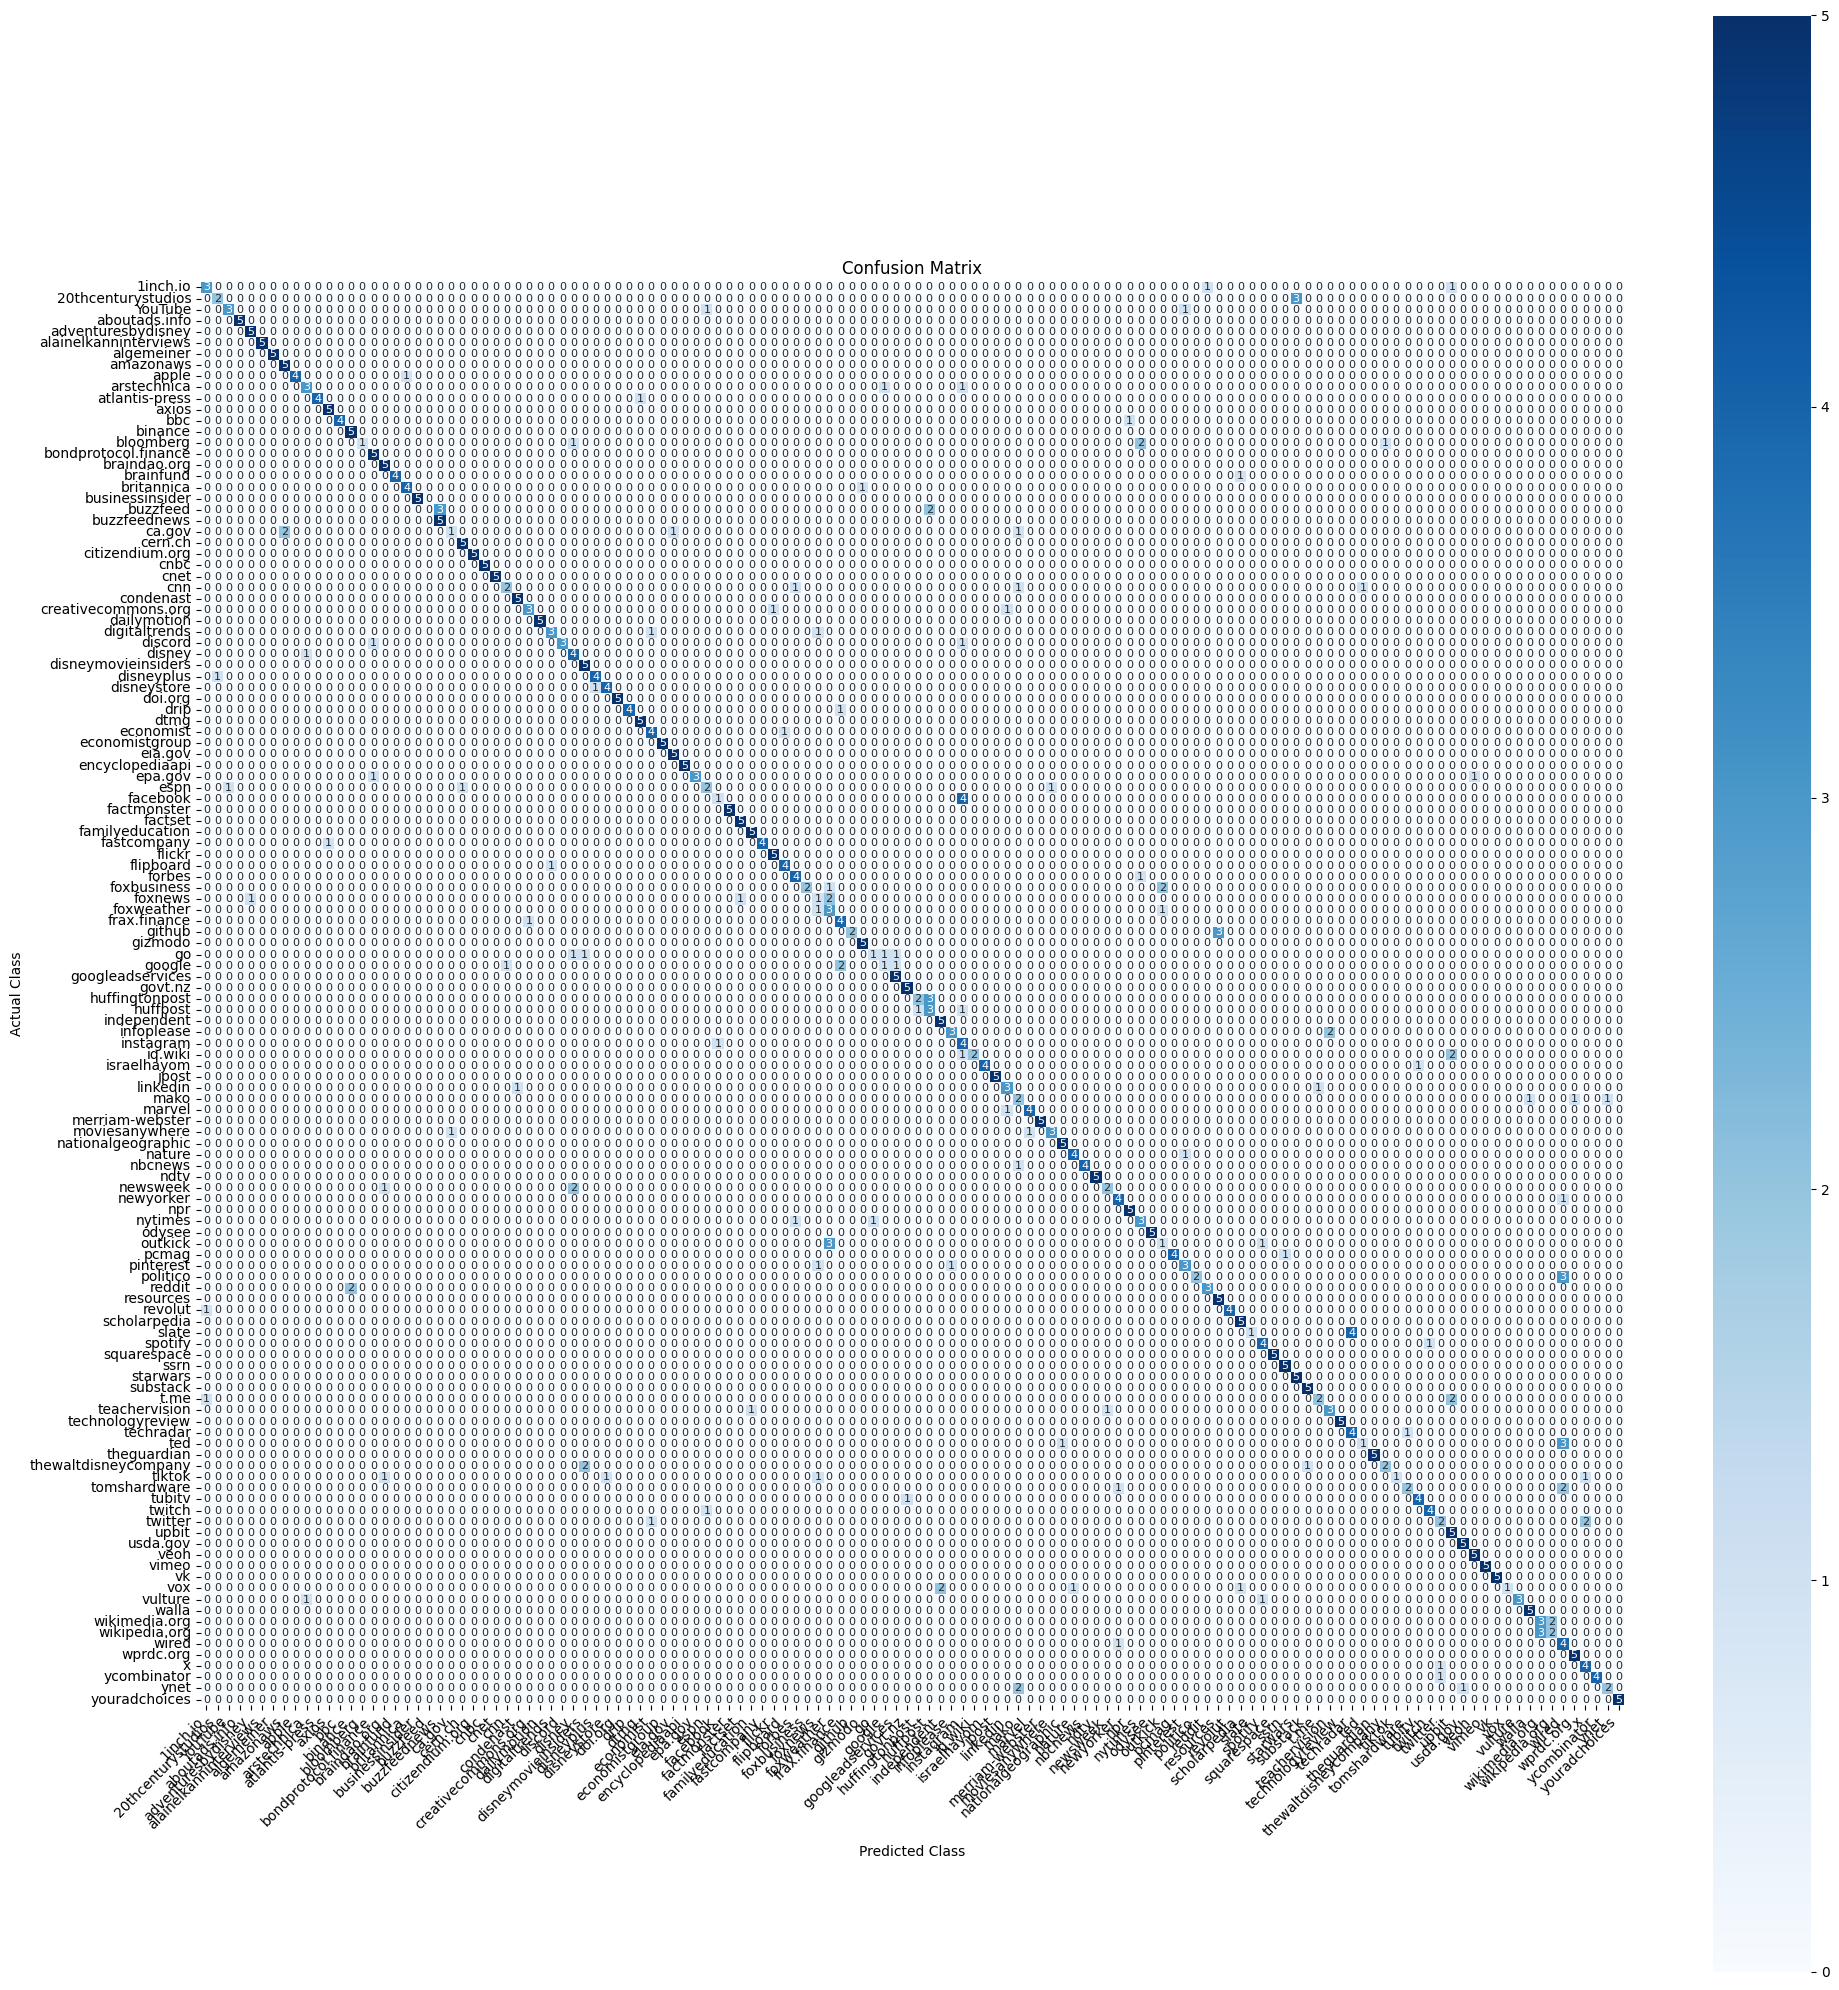


Analyzing chronic misclassifications (threshold >= 2):

Format: ACTUAL_WEBSITE was misclassified as PREDICTED_WEBSITE X times

MISS: '20thcenturystudios' was misclassified as 'starwars' : 3 times
MISS: 'bloomberg' was misclassified as 'nytimes' : 2 times
MISS: 'buzzfeed' was misclassified as 'buzzfeednews' : 3 times
MISS: 'buzzfeed' was misclassified as 'huffpost' : 2 times
MISS: 'ca.gov' was misclassified as 'amazonaws' : 2 times
MISS: 'facebook' was misclassified as 'instagram' : 4 times
MISS: 'foxbusiness' was misclassified as 'outkick' : 2 times
MISS: 'foxnews' was misclassified as 'foxweather' : 2 times
MISS: 'github' was misclassified as 'resources' : 3 times
MISS: 'google' was misclassified as 'frax.finance' : 2 times
MISS: 'huffingtonpost' was misclassified as 'huffpost' : 3 times
MISS: 'infoplease' was misclassified as 'teachervision' : 2 times
MISS: 'iq.wiki' was misclassified as 'upbit' : 2 times
MISS: 'newsweek' was misclassified as 'disney' : 2 times
MISS: 'outkick' was m

In [195]:
# Define the feature counts to test
feature_counts = [3, 5, 8, 10, 16, 20, 25]
results = {}

# Random Forest predictions
rf_test_predictions = rf_model.predict(test_df)
print("\nRandom Forest Performance on Test Set:")
rf_accuracy = accuracy_score(test_labels, rf_test_predictions)

print("\nEvaluating different numbers of top features...")

# Store best performance metrics
best_accuracy = 0
best_feature_count = None
best_predictions = None
best_classifier = None
best_features = None

for num_features in feature_counts:
    print(f"\n=== Testing with top {num_features} features ===")
    
    # Get top features for this iteration
    top_features = feature_importance.head(num_features)['feature'].tolist()
    print("Selected features:")
    for i, feat in enumerate(top_features, 1):
        importance = feature_importance[feature_importance['feature'] == feat]['importance'].iloc[0]
        print(f"{i}. {feat} (importance: {importance:.4f})")

    # Create datasets with selected features
    X_top = X[top_features]
    test_df_top = test_df[top_features]

    # Check class distribution
    class_counts = pd.Series(y).value_counts()
    min_samples = class_counts.min()
    n_splits = min(3, min_samples)

    # Initialize and train Bagging Classifier
    bag_clf = BaggingClassifier(
        n_estimators=400,
        max_samples=0.85,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=True,
        random_state=42,
        n_jobs=-1
    )

    # Perform cross-validation if possible
    cv_scores = None
    if n_splits > 1:
        try:
            cv_scores = cross_val_score(bag_clf, X_top, y, cv=n_splits)
            print(f"Cross-validation scores: {cv_scores}")
            print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        except ValueError as e:
            print(f"Could not perform cross-validation: {e}")

    # Train on full training data
    bag_clf.fit(X_top, y)

    # Make predictions
    bag_test_predictions = bag_clf.predict(test_df_top)
    bag_accuracy = accuracy_score(test_labels, bag_test_predictions)

    # Store results
    results[num_features] = {
        'accuracy': bag_accuracy,
        'cv_scores': cv_scores,
        'predictions': bag_test_predictions,
        'classifier': bag_clf,
        'features': top_features
    }

    print(f"\nBagging Classifier Performance (top {num_features} features):")
    print(f"Accuracy: {bag_accuracy:.4f}")

    # Update best model if current is better
    if bag_accuracy > best_accuracy:
        best_accuracy = bag_accuracy
        best_feature_count = num_features
        best_predictions = bag_test_predictions
        best_classifier = bag_clf
        best_features = top_features

# Print summary of all results
print("\n=== Summary of Results ===")
print("\nAccuracies for different feature counts:")
for num_features, result in results.items():
    print(f"Top {num_features} features: {result['accuracy']:.4f}")

print(f"\nBest performance achieved with {best_feature_count} features")
print(f"Best accuracy: {best_accuracy:.4f}")
print("\nBest features:")
for i, feat in enumerate(best_features, 1):
    importance = feature_importance[feature_importance['feature'] == feat]['importance'].iloc[0]
    print(f"{i}. {feat} (importance: {importance:.4f})")

# Save only the best model's predictions
predictions_df = pd.DataFrame({
    'True_Label': test_labels,
    'Predicted_Label': best_predictions,
    'Correct': test_labels == best_predictions
})

# Compare with Random Forest
print("\n=== Final Model Comparison ===")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Best Bagging Classifier Accuracy: {best_accuracy:.4f}")
print(f"Difference: {abs(rf_accuracy - best_accuracy):.4f}")

# Save model performance metrics
performance_df = pd.DataFrame({
    'Model': ['Random Forest', 'Best Bagging Classifier'],
    'Accuracy': [rf_accuracy, best_accuracy],
    'Feature_Count': [len(X.columns), best_feature_count]
})

# Create and show a confusion matrix and analysis:
chronic_misclassifications, perfect_classes = plot_confusion_matrix(test_labels, best_predictions)


In [196]:
def clean_and_scale_data(X_train, X_test):
    """Clean and scale data, handling infinities and large values"""
    # Create copies to avoid modifying originals
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()
    
    # Replace infinities with large but finite values
    X_train_clean = X_train_clean.replace([np.inf, -np.inf], np.nan)
    X_test_clean = X_test_clean.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaN values with median of column
    for col in X_train_clean.columns:
        median = X_train_clean[col].median()
        X_train_clean[col] = X_train_clean[col].fillna(median)
        X_test_clean[col] = X_test_clean[col].fillna(median)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    
    # Convert back to DataFrame to keep column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)
    
    return X_train_scaled, X_test_scaled

def get_misclassified_groups(chronic_misclassifications):
    """
    Extract groups of related misclassifications.
    E.g., if facebook -> instagram and facebook -> twitter, 
    return [facebook, instagram, twitter] as one group
    """
    # Create a dictionary to store related classes
    class_groups = {}
    
    # Build groups of related classes
    for misclass in chronic_misclassifications:
        actual = misclass['actual']
        predicted = misclass['predicted']
        
        # If either class is already in a group, add both to that group
        found_group = False
        for group_id, group in list(class_groups.items()):
            if actual in group or predicted in group:
                group.add(actual)
                group.add(predicted)
                found_group = True
                # Check if this group should be merged with any other group
                for other_id, other_group in list(class_groups.items()):
                    if other_id != group_id and (actual in other_group or predicted in other_group):
                        group.update(other_group)
                        del class_groups[other_id]
                break
        
        # If neither class is in any group, create a new group
        if not found_group:
            class_groups[len(class_groups)] = {actual, predicted}
    
    # Convert to list of lists
    return [list(group) for group in class_groups.values()]

def train_on_class_group(X, y, test_df, test_labels, class_group, feature_importance,
                        social_media_features_train, social_media_features_test,
                        targeted_features_train, targeted_features_test,
                        enhanced_features_train, enhanced_features_test):
    """Train and evaluate models on a group of related problematic classes"""
    
    # Filter data for this group of classes
    group_mask_train = y.isin(class_group)
    group_mask_test = test_labels.isin(class_group)
    
    X_group = X[group_mask_train].copy()
    y_group = y[group_mask_train].copy()
    test_df_group = test_df[group_mask_test].copy()
    test_labels_group = test_labels[group_mask_test].copy()
    
    # Filter pre-calculated features
    social_media_group_train = social_media_features_train[group_mask_train].copy()
    social_media_group_test = social_media_features_test[group_mask_test].copy()
    targeted_group_train = targeted_features_train[group_mask_train].copy()
    targeted_group_test = targeted_features_test[group_mask_test].copy()
    enhanced_group_train = enhanced_features_train[group_mask_train].copy()
    enhanced_group_test = enhanced_features_test[group_mask_test].copy()
    
    # Train Random Forest baseline
    rf_group = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Clean and scale the data
    X_group_clean, test_df_group_clean = clean_and_scale_data(X_group, test_df_group)
    
    rf_group.fit(X_group_clean, y_group)

    # print the feature importance to the terminal:
    feature_importance = pd.DataFrame({
        'feature': X_group.columns,
        'importance': rf_group.feature_importances_
    }).sort_values('importance', ascending=False)
    print(f"\nFeature importance for group: {' - '.join(class_group)}")
    print(feature_importance)
    
    rf_predictions = rf_group.predict(test_df_group_clean)
    rf_accuracy = accuracy_score(test_labels_group, rf_predictions)
    
    feature_counts = [3, 5, 8, 10, 16, 20, 25]
    best_accuracy = 0
    best_predictions = None
    
    print(f"\nTraining on group: {' - '.join(class_group)}")
    print(f"Initial RF accuracy: {rf_accuracy:.4f}")
    
    for num_features in feature_counts:
        # Get top features for this iteration
        top_features = feature_importance.head(num_features)['feature'].tolist()
        
        # Create datasets with selected features
        X_top = pd.DataFrame(index=X_group.index)
        test_df_top = pd.DataFrame(index=test_df_group.index)
        
        # Add top features
        for feat in top_features:
            X_top[feat] = X_group[feat].values
            test_df_top[feat] = test_df_group[feat].values
        
        # Add social media features
        for col in social_media_group_train.columns:
            X_top[col] = social_media_group_train[col].values
            test_df_top[col] = social_media_group_test[col].values
        
        # Add targeted features
        for col in targeted_group_train.columns:
            X_top[col] = targeted_group_train[col].values
            test_df_top[col] = targeted_group_test[col].values
        
        # Add enhanced features
        for col in enhanced_group_train.columns:
            X_top[col] = enhanced_group_train[col].values
            test_df_top[col] = enhanced_group_test[col].values
        
        # Clean and scale the combined data
        X_top_clean, test_df_top_clean = clean_and_scale_data(X_top, test_df_top)
        
        # Train Bagging Classifier
        bag_clf = BaggingClassifier(
            n_estimators=400,
            max_samples=0.85,
            max_features=1.0,
            bootstrap=True,
            bootstrap_features=True,
            random_state=42,
            n_jobs=-1
        )
        
        try:
            bag_clf.fit(X_top_clean, y_group)
            bag_predictions = bag_clf.predict(test_df_top_clean)
            bag_accuracy = accuracy_score(test_labels_group, bag_predictions)
            
            print(f"Accuracy with {num_features} features: {bag_accuracy:.4f}")
            
            if bag_accuracy > best_accuracy:
                best_accuracy = bag_accuracy
                best_predictions = bag_predictions
                
        except Exception as e:
            print(f"Error training with {num_features} features: {str(e)}")
            continue
    
    if best_predictions is None:
        print("Warning: Using RF predictions as fallback")
        best_predictions = rf_predictions
        best_accuracy = rf_accuracy
    
    return test_labels_group, best_predictions, best_accuracy, confusion_matrix(test_labels_group, best_predictions)

def refine_and_retrain(X, y, test_df, test_labels, chronic_misclassifications, best_predictions, 
                      social_media_features_train, social_media_features_test,
                      targeted_features_train, targeted_features_test,
                      enhanced_features_train, enhanced_features_test):
    """
    Refine datasets by analyzing groups of related misclassified classes
    """
    print("\nRefining datasets...")
    
    # Get groups of related problematic classes
    class_groups = get_misclassified_groups(chronic_misclassifications)
    print(f"\nNumber of class groups identified: {len(class_groups)}")
    for i, group in enumerate(class_groups, 1):
        print(f"Group {i}: {' - '.join(group)}")
    
    # Calculate feature importance once for use with all groups
    rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf_model.fit(X, y)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Store results for each group
    group_results = {}
    final_predictions = test_labels.copy()
    
    # Process each group
    for group in class_groups:
        print(f"\nProcessing group: {' - '.join(group)}")
        
        group_labels, group_predictions, group_accuracy, group_cm = train_on_class_group(
            X, y, test_df, test_labels, group, feature_importance,
            social_media_features_train, social_media_features_test,
            targeted_features_train, targeted_features_test,
            enhanced_features_train, enhanced_features_test
        )
        
        # Store results
        group_results[tuple(group)] = {
            'accuracy': group_accuracy,
            'confusion_matrix': group_cm,
            'classification_report': classification_report(group_labels, group_predictions)
        }
        
        # Update predictions for this group in final predictions
        group_mask = test_labels.isin(group)
        final_predictions[group_mask] = group_predictions
    
    # Print summary of group results
    print("\nGroup-wise Results Summary:")
    print("-" * 50)
    for group, results in group_results.items():
        print(f"\nGroup: {' - '.join(group)}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print("\nConfusion Matrix:")
        print(results['confusion_matrix'])
        print("\nClassification Report:")
        print(results['classification_report'])
    
    # Calculate and print final overall accuracy
    final_accuracy = accuracy_score(test_labels, final_predictions)
    print(f"\nFinal Overall Accuracy: {final_accuracy:.4f}")
    
    return final_predictions, group_results


Refining datasets...

Number of class groups identified: 11
Group 1: starwars - 20thcenturystudios
Group 2: bloomberg - nytimes
Group 3: huffpost - huffingtonpost - buzzfeed - buzzfeednews
Group 4: amazonaws - ca.gov
Group 5: instagram - facebook
Group 6: foxnews - outkick - foxweather - foxbusiness
Group 7: resources - github
Group 8: frax.finance - google
Group 9: teachervision - infoplease
Group 10: t.me - upbit - iq.wiki
Group 11: mako - ynet

Processing group: starwars - 20thcenturystudios

Feature importance for group: starwars - 20thcenturystudios
                  feature  importance
31   first_packet_sizes_8    0.063872
57        mean_delta_byte    0.061582
85  bwd_timing_regularity    0.052963
27   first_packet_sizes_4    0.042094
58         STD_delta_byte    0.040402
..                    ...         ...
9          min_bwd_packet    0.000000
8          max_bwd_packet    0.000000
7          min_fwd_packet    0.000000
6         max_fwd_packet     0.000000
89            day_of

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


Feature importance for group: foxnews - outkick - foxweather - foxbusiness
                 feature  importance
55      mean_packet_size    0.044137
0         Destination_IP    0.040850
69               pps_fwd    0.040037
66                 bpp_1    0.039329
56       STD_packet_size    0.035874
..                   ...         ...
64           bandwidth_9    0.000000
63           bandwidth_7    0.000000
62           bandwidth_5    0.000000
60           bandwidth_2    0.000000
25  first_packet_sizes_2    0.000000

[90 rows x 2 columns]

Training on group: foxnews - outkick - foxweather - foxbusiness
Initial RF accuracy: 0.4500
Accuracy with 3 features: 0.5000
Accuracy with 5 features: 0.4000
Accuracy with 8 features: 0.4000
Accuracy with 10 features: 0.4500
Accuracy with 16 features: 0.4500
Accuracy with 20 features: 0.6000
Accuracy with 25 features: 0.4500

Processing group: resources - github

Feature importance for group: resources - github
                    feature  importance
6

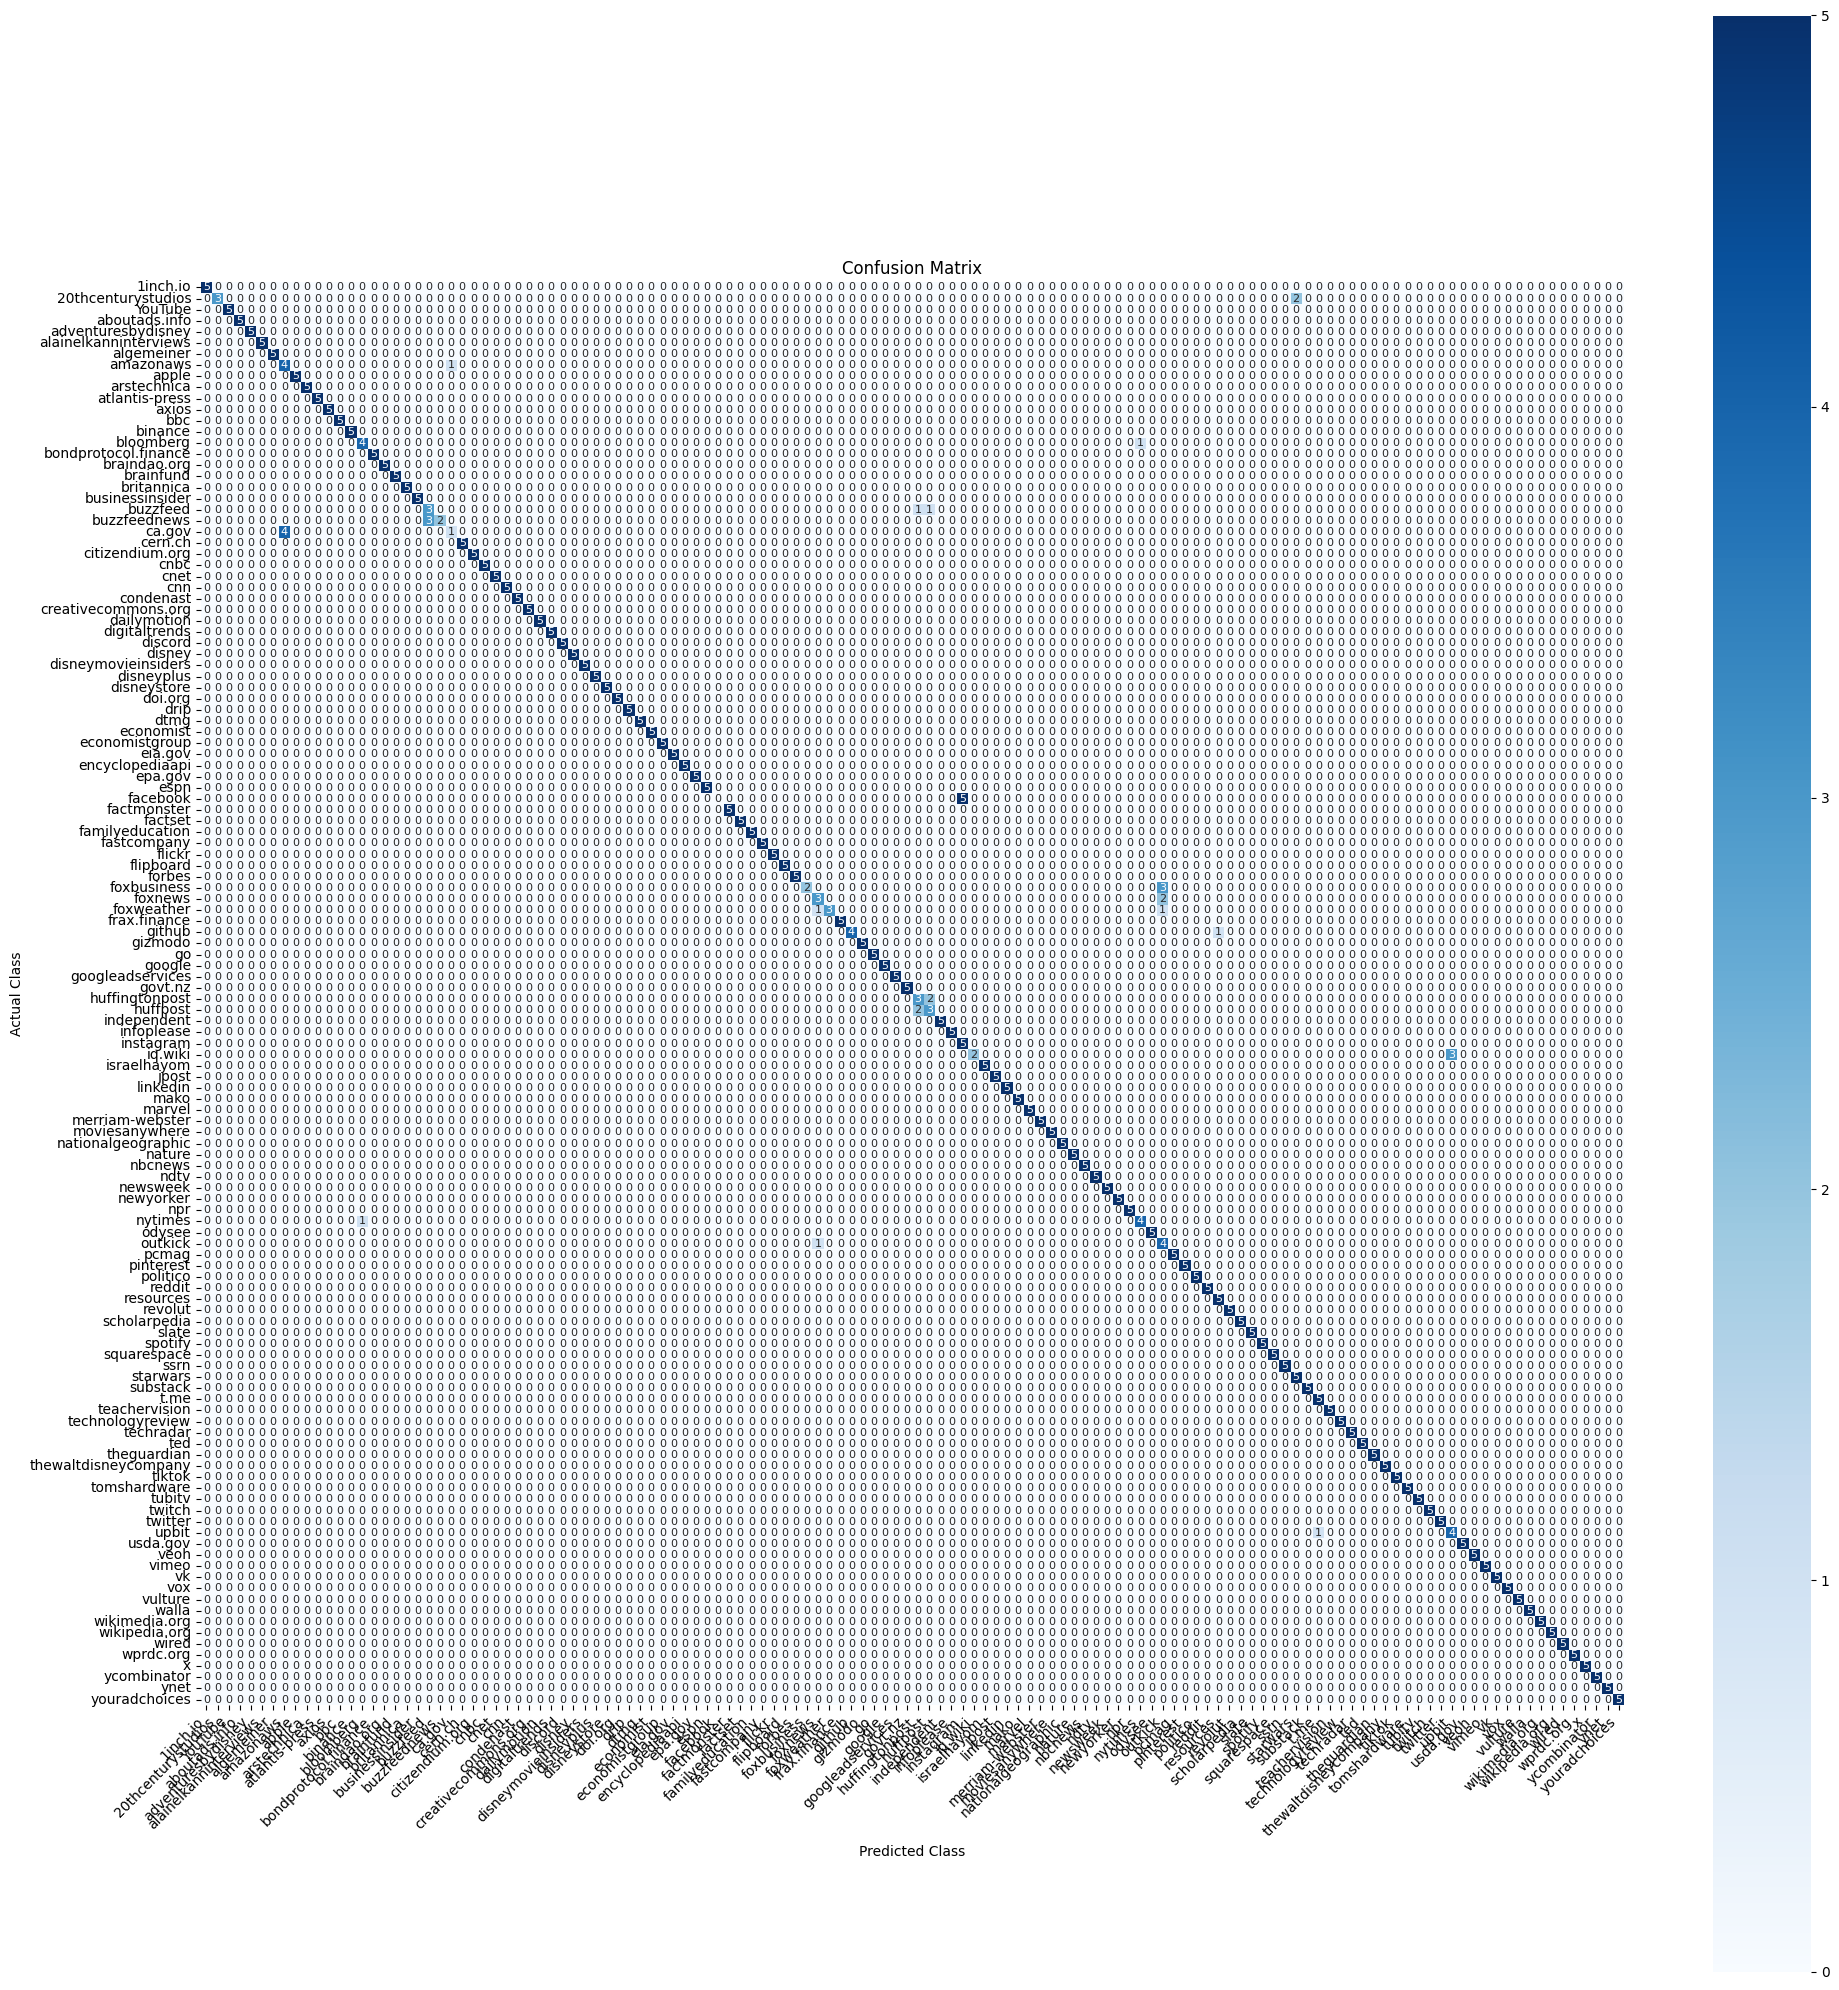


Analyzing chronic misclassifications (threshold >= 2):

Format: ACTUAL_WEBSITE was misclassified as PREDICTED_WEBSITE X times

MISS: '20thcenturystudios' was misclassified as 'starwars' : 2 times
MISS: 'buzzfeednews' was misclassified as 'buzzfeed' : 3 times
MISS: 'ca.gov' was misclassified as 'amazonaws' : 4 times
MISS: 'facebook' was misclassified as 'instagram' : 5 times
MISS: 'foxbusiness' was misclassified as 'outkick' : 3 times
MISS: 'foxnews' was misclassified as 'outkick' : 2 times
MISS: 'huffingtonpost' was misclassified as 'huffpost' : 2 times
MISS: 'huffpost' was misclassified as 'huffingtonpost' : 2 times
MISS: 'iq.wiki' was misclassified as 'upbit' : 3 times

Misclassification Percentages (all cases):
--------------------------------------------------
20thcenturystudios → starwars: 40.0% (2/5 samples)
amazonaws → ca.gov: 20.0% (1/5 samples)
bloomberg → nytimes: 20.0% (1/5 samples)
buzzfeed → huffingtonpost: 20.0% (1/5 samples)
buzzfeed → huffpost: 20.0% (1/5 samples)
buzz

([{'actual': '20thcenturystudios',
   'predicted': 'starwars',
   'count': 2,
   'percentage': 40.0},
  {'actual': 'buzzfeednews',
   'predicted': 'buzzfeed',
   'count': 3,
   'percentage': 60.0},
  {'actual': 'ca.gov',
   'predicted': 'amazonaws',
   'count': 4,
   'percentage': 80.0},
  {'actual': 'facebook',
   'predicted': 'instagram',
   'count': 5,
   'percentage': 100.0},
  {'actual': 'foxbusiness',
   'predicted': 'outkick',
   'count': 3,
   'percentage': 60.0},
  {'actual': 'foxnews',
   'predicted': 'outkick',
   'count': 2,
   'percentage': 40.0},
  {'actual': 'huffingtonpost',
   'predicted': 'huffpost',
   'count': 2,
   'percentage': 40.0},
  {'actual': 'huffpost',
   'predicted': 'huffingtonpost',
   'count': 2,
   'percentage': 40.0},
  {'actual': 'iq.wiki', 'predicted': 'upbit', 'count': 3, 'percentage': 60.0}],
 ['1inch.io',
  'YouTube',
  'aboutads.info',
  'adventuresbydisney',
  'alainelkanninterviews',
  'algemeiner',
  'apple',
  'arstechnica',
  'atlantis-pres

In [197]:
# Later, after your first Random Forest and Bagging runs:
final_predictions, group_results = refine_and_retrain(
    X, y, test_df, test_labels, chronic_misclassifications, best_predictions,
    social_media_features_train, social_media_features_test,
    targeted_features_train, targeted_features_test, 
    enhanced_features_train, enhanced_features_test
)

# print the final confusion matrix and analysis:
plot_confusion_matrix(test_labels, final_predictions)

In [ ]:
print("\nModel training and prediction completed!")
# print("Predictions saved to 'random_forest_predictions.csv'")